In [2]:
import pandas as pd
import csv
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
csv.field_size_limit(500 * 1024 * 1024)

131072

In [3]:
df_youtube = pd.read_csv('./1006/youtube_affiliate_comments.csv', engine = 'python')

In [21]:
# df_youtube = df_youtube.reindex(columns=df_youtube.columns.to_list() + ['affiliate_url_count'])
# df_youtube.affiliate_url_count = 0

In [22]:
# ddd = pd.read_csv('./1006/youtube_results_0915.csv', engine = 'python')

In [23]:
# affiliate_url_list = list(set(ddd[ddd['isAffiliateLink'] == 1].url.to_list()))

In [24]:
# from tqdm import tqdm
# import ast
# for i in tqdm(range(len(df_youtube))):
#     count = 0
#     for url in ast.literal_eval(df_youtube.loc[i, 'urls']):
#         if url in affiliate_url_list:
#             count = count + 1
#     df_youtube.loc[i, 'affiliate_url_count'] = count

100%|██████████| 15786/15786 [00:12<00:00, 1281.43it/s]


In [27]:
# df_youtube.to_csv('./1006/youtube_affiliate_comments.csv', index = False)

In [4]:
df_youtube.shape

(15786, 13)

15786条评论来自1598个不同的用户

In [5]:
df_youtube.authorId.nunique()

1598

有4名用户发布的affiliate comments超过了1000条，共5118条。（32.42%）

In [6]:
df_youtube.authorId.value_counts()

UCkw4JCwteGrDHIsyIIKo4tQ    1544
UC3o3cUNVrcwrEE6B9CNGDbw    1273
UCc0KPctILg6USaDJS6tcJgg    1271
UCSE72IaHOL-1Tv-m3JHE4Cg    1030
UCsvqVGtbbyHaMoevxPAq9Fg     414
                            ... 
UC20VPL2lPtNChvyJORjCUUw       1
UCuZb13gB3bNo2L2VODzYAGg       1
UCF9-JngqznvAsiF2yZbeY8g       1
UChmkRFkzzzrmN4nAq6_7WeQ       1
UCw7Dzi5OdZsv0Xx9xNrasmw       1
Name: authorId, Length: 1598, dtype: int64

- 评论发布者与视频发布者为同一人

In [7]:
df_youtube[df_youtube['channelcommentpostedon']==df_youtube['authorId']].shape[0]

14533

- 评论发布者与视频发布者不是同一人

In [8]:
df_youtube[df_youtube['channelcommentpostedon']!=df_youtube['authorId']].shape[0]

1253

- 时间差计算

In [9]:
df_afcomments_groupby_authorid=df_youtube.groupby('authorId')

In [10]:
import time
from datetime import datetime

def date_time_str_to_long(input_date_time_string):
    dt = datetime.strptime(input_date_time_string, '%Y-%m-%dT%H:%M:%SZ')
    timeStamp = dt.timestamp()
    return timeStamp


def date_time_count(startTime, endTime):
    '''
    计算两个时间之间的差值，精确到秒
    :param startTime:
    :param endTime:
    :return:
    '''
    spent_times = int(date_time_str_to_long(endTime)) - int(date_time_str_to_long(startTime))
    # print('endTime={},startTime={},时间差值={}'.format(endTime, startTime, spent_times))
    return spent_times

In [13]:
from tqdm import tqdm

df_time_delta=pd.DataFrame(columns=['authorId', 'minDelta', 'maxDelta', 'commentDates','deltas', 'commentCount'])

for authorId, group in tqdm(df_afcomments_groupby_authorid):  # 遍历.DataFrameGroupBy对象
    # print(authorId, len(group))
    # 所有评论发布的时间
    comments_date=[]
    deltas=[]
    for i in range(len(group)):
        comments_date.append(group.iloc[i, 3])
    comments_date = sorted(comments_date)
    # 计算差值
    for i in range(len(comments_date)-1, 0, -1):
        delta=date_time_count(comments_date[i-1], comments_date[i])
        deltas.append(delta)
    mi, ma = None, None
    if deltas:
        mi=min(deltas)
        ma=max(deltas)
    time_delta = {
        "authorId": authorId,
        "minDelta": mi,
        "maxDelta": ma,
        "commentDates": comments_date,
        "deltas": deltas,
        "commentCount": len(group)
    }
    df_time_delta.loc[len(df_time_delta)] = time_delta

100%|██████████| 1598/1598 [00:05<00:00, 300.44it/s]


In [14]:
df_time_delta = df_time_delta.reindex(columns=df_time_delta.columns.to_list() + ['meanDelta'])
df_time_delta.meanDelta = None

In [15]:
from tqdm import tqdm

for i in tqdm(range(len(df_time_delta))):
    if df_time_delta.loc[i, 'deltas']:
        count = len(df_time_delta.loc[i, 'deltas'])
        df_time_delta.loc[i, 'meanDelta'] = sum(df_time_delta.loc[i, 'deltas'])/count

100%|██████████| 1598/1598 [00:00<00:00, 10628.48it/s]


In [51]:
df_top_20 = df_time_delta.sort_values('commentCount', ascending = False).head(20)

In [53]:
df_top_20.reset_index(inplace = True)

In [54]:
df_top_20

,index,authorId,minDelta,maxDelta,commentDates,deltas,commentCount,meanDelta
0,1232,UCkw4JCwteGrDHIsyIIKo4tQ,6,233718,"[2021-11-25T07:45:30Z, 2021-11-25T08:18:20Z, 2...","[9496, 2653, 22428, 2203, 81, 32, 83703, 31, 2...",1544,13163.593001
1,131,UC3o3cUNVrcwrEE6B9CNGDbw,3,2171863,"[2021-12-07T20:44:58Z, 2021-12-10T20:08:37Z, 2...","[183331, 76229, 4964, 3766, 6439, 7484, 435585...",1273,14875.705189
2,1021,UCc0KPctILg6USaDJS6tcJgg,1,50860611,"[2020-05-22T20:12:50Z, 2020-07-03T15:10:07Z, 2...","[297, 50860611, 126, 134, 147, 129, 235, 117, ...",1271,53383.299213
3,748,UCSE72IaHOL-1Tv-m3JHE4Cg,2,4152632,"[2021-11-19T12:00:08Z, 2021-11-19T12:09:35Z, 2...","[20, 39, 20, 21, 23, 54, 31, 20, 19, 20, 21, 2...",1030,20828.01069
4,1431,UCsvqVGtbbyHaMoevxPAq9Fg,27,100384884,"[2015-08-25T14:31:02Z, 2015-10-26T13:26:15Z, 2...","[174677, 424885, 168968, 456131, 2629, 152308,...",414,526536.138015
5,746,UCS9OE6KeXQ54nSMqhRx0_EQ,23,1619886,"[2020-01-08T17:09:38Z, 2020-01-09T11:03:52Z, 2...","[68762, 512926, 15688, 93121, 384506, 50680, 1...",406,195770.209877
6,362,UCBkvic2-pCrd1VzVXnh6_Vg,6,5460248,"[2019-12-13T16:43:14Z, 2019-12-13T16:44:58Z, 2...","[63525, 331545, 174606, 98124, 183501, 69360, ...",321,257423.909375
7,939,UCZbNi5DqBvaOZygMl8HfjDQ,7,529956,"[2022-03-23T17:23:04Z, 2022-03-23T17:29:57Z, 2...","[15, 11, 18, 14, 10, 12, 20, 10, 11, 7, 8, 10,...",275,21058.529197
8,656,UCNc4FB7ylWM0LBx0rx8SyZA,14,2067819,"[2022-01-25T12:11:35Z, 2022-02-18T10:35:14Z, 2...","[5233, 13479, 144475, 1700, 11348, 10402, 8396...",275,52426.328467
9,369,UCC06zokQMplHNWKN79FTd2w,8,41468391,"[2020-11-26T02:49:22Z, 2020-11-26T02:49:35Z, 2...","[342124, 8, 9, 41468391, 138, 398, 146, 3263, ...",261,187814.061538


In [43]:
df_time_delta.sort_values('minDelta')

,authorId,minDelta,maxDelta,commentDates,deltas,commentCount,meanDelta
2,UC-1xWddB-H8_uVdpXJ1qFnw,0,0,"[2022-06-21T06:26:56Z, 2022-06-21T06:26:56Z]",[0],2,0.0
1582,UCzND5Kjq4-zoy8LvbvHJTmA,0,0,"[2022-07-07T18:52:53Z, 2022-07-07T18:52:53Z]",[0],2,0.0
786,UCTlnaHHQ75zlDg_fLr7tGEg,0,0,"[2022-07-26T08:37:31Z, 2022-07-26T08:37:31Z]",[0],2,0.0
1021,UCc0KPctILg6USaDJS6tcJgg,1,50860611,"[2020-05-22T20:12:50Z, 2020-07-03T15:10:07Z, 2...","[297, 50860611, 126, 134, 147, 129, 235, 117, ...",1271,53383.299213
748,UCSE72IaHOL-1Tv-m3JHE4Cg,2,4152632,"[2021-11-19T12:00:08Z, 2021-11-19T12:09:35Z, 2...","[20, 39, 20, 21, 23, 54, 31, 20, 19, 20, 21, 2...",1030,20828.01069
...,...,...,...,...,...,...,...
1592,UCzlb7-RxHTU8WriwZUE2qWw,None,None,[2022-07-27T08:29:04Z],[],1,None
1593,UCzr4Htx5Rm8h-1FWkRw_H0Q,None,None,[2022-06-16T09:07:03Z],[],1,None
1594,UCzsM70r0JtXMnnbzOZUh5qw,None,None,[2015-11-14T19:40:26Z],[],1,None
1596,UCzuRUc2UJQTL-P8hQCIKstA,None,None,[2020-11-03T16:59:00Z],[],1,None


In [45]:
df_time_delta[['minDelta']].value_counts()

minDelta
14          8
16          6
8           5
33          5
15          5
           ..
84005       1
81619       1
81588       1
81396       1
60565181    1
Length: 436, dtype: int64

In [61]:
df_top_10 = df_time_delta.sort_values('commentCount', ascending = False).head(10)
df_top_10.reset_index(inplace = True)

In [93]:
df_top_10[['maxDelta']]/86400   # 按天数计算

,maxDelta
0,2.705069
1,25.137303
2,588.664479
3,48.06287
4,1161.862083
5,18.748681
6,63.197315
7,6.13375
8,23.93309
9,479.958229


发布评论最多的top10用户发布评论的时间间隔统计

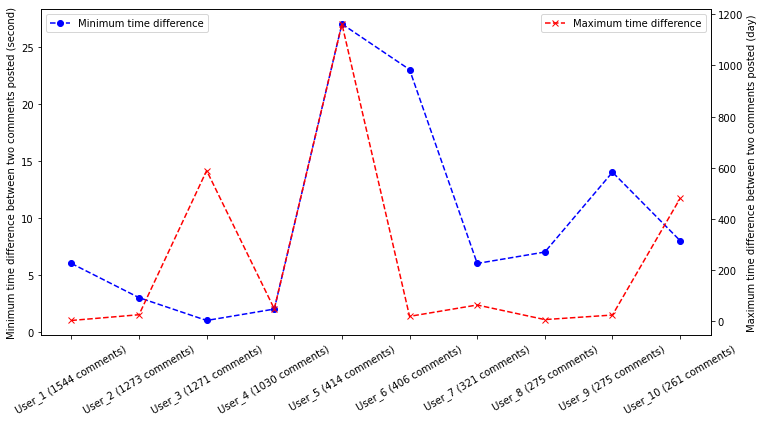

In [123]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

delta_min = df_top_10[['minDelta']]
delta_max = df_top_10[['maxDelta']]/86400
comment_count = df_top_10.commentCount.to_list()
for i in range(len(comment_count)):
    comment_count[i] = "User_" + str(i+1) + " (" + str(comment_count[i]) + " comments)"


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
# plt.figure(figsize=(12, 6)) 
ax1.plot(delta_min, marker="o", color="blue", label="Minimum time difference", linestyle="--")
# ax1.set_xlabel('Top 10 user posting affiliate URLs')
# plt.ylabel('Minimum time difference between two comments posted (second)')
plt.xticks(range(len(delta_min)), comment_count, rotation = 30)
ax1.set_ylabel('Minimum time difference between two comments posted (second)')

ax2 = ax1.twinx()
ax2.plot(delta_max, marker="x", label = "Maximum time difference", color="red", linestyle="--")
ax2.set_ylabel('Maximum time difference between two comments posted (day)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('./figs/youtube_top10_min_max_Delta.pdf', bbox_inches='tight')  # ***bbox_inches='tight'***防止x轴显示不全
plt.show()

发布评论最多的top20用户发布评论的时间间隔统计(单位为day)

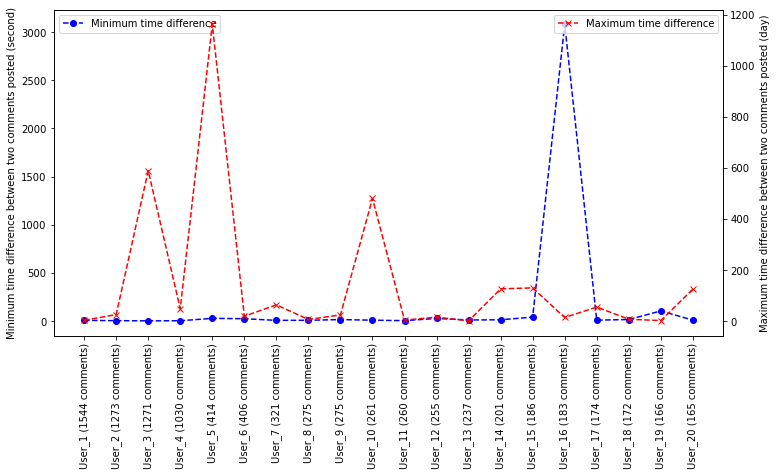

In [124]:
import matplotlib.pyplot as plt

delta_min = df_top_20[['minDelta']]
delta_max = df_top_20[['maxDelta']]/86400

comment_count = df_top_20.commentCount.to_list()
for i in range(len(comment_count)):
    comment_count[i] = "User_" + str(i+1) + " (" + str(comment_count[i]) + " comments)"


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
# plt.figure(figsize=(12, 6)) 
ax1.plot(delta_min, marker="o", color="blue", label="Minimum time difference", linestyle="--")
# ax1.set_xlabel('Top 20 user posting affiliate URLs')
# plt.ylabel('Minimum time difference between two comments posted (second)')
plt.xticks(range(len(delta_min)), comment_count, rotation = 90)
ax1.set_ylabel('Minimum time difference between two comments posted (second)')

ax2 = ax1.twinx()
ax2.plot(delta_max, marker="x", label = "Maximum time difference", color="red", linestyle="--")
ax2.set_ylabel('Maximum time difference between two comments posted (day)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig('./figs/youtube_top20_min_max_Delta.pdf', bbox_inches='tight') 
plt.show()

In [41]:
df_time_delta.to_csv('./1010/youtube_time_difference.csv', index = False)

---